# Title

## 732A92 Text Mining

Chenjianshi

2022-01-11

## Data Access

In [1]:
from google_play_scraper import Sort, reviews_all
import pandas as pd


def scrap_data(score,data_csv,country):
    result = reviews_all(
        'com.miHoYo.GenshinImpact',
        sleep_milliseconds=0,  # defaults to 0
        lang='en',  # defaults to 'en'
        country=country,  # defaults to 'us'
        sort=Sort.MOST_RELEVANT,  # defaults to Sort.MOST_RELEVANT
        filter_score_with=score  # defaults to None(means all score)
    )

    for i in range(len(result)):
        temp = pd.DataFrame({'Time': result[i]["at"], 'Score': result[i]["score"], 'Content': result[i]['content']},
                            index=[0])

        data_csv = data_csv.append(temp, ignore_index=True)
        pass
    return data_csv


def scrap_data_to_csv(country):
    data_csv = pd.DataFrame(columns=['Time', 'Score', 'Content'])
    print('Scrapping 5 score data')
    data_csv = scrap_data(5, data_csv, country)
    print('Scrapping 4 score data')
    data_csv = scrap_data(4, data_csv, country)
    print('Scrapping 3 score data')
    data_csv = scrap_data(3, data_csv, country)
    print('Scrapping 2 score data')
    data_csv = scrap_data(2, data_csv, country)
    print('Scrapping 1 score data')
    data_csv = scrap_data(1, data_csv, country)
    print('Saving data')
    data_len = len(data_csv)
    filename = 'data_' + (str(data_len )[:2]) + 'k_' + country + '.xlsx'
    data_csv.to_excel(filename, index=False)
    pass


# Not run
# scrap_data_to_csv('us')

## Data Overview

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection

In [3]:
data = pd.read_excel('data_38k_us.xlsx')

In [4]:
data

,Time,Score,Content
0,2022-01-05 04:22:08,5,I literally love this game. Playing on a phone...
1,2022-01-07 04:54:02,5,"The game itself is wonderful and enchanting, I..."
2,2022-01-08 00:08:37,5,This is an amazing game it has amazing graphic...
3,2022-01-04 23:52:11,5,Full fledged game that you can play for free. ...
4,2022-01-05 01:08:32,5,This game is so fun! The story is thrilling an...
...,...,...,...
38593,2021-10-14 09:23:25,1,I can't even play it.I just dowloaded it and I...
38594,2021-09-29 11:21:58,1,"The game has been fun so far, although the upd..."
38595,2021-09-29 05:19:42,1,Aniversary awards sucks as hell. This game dev...
38596,2021-09-28 20:33:23,1,Overall a very good game with very good story....


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
data_train,data_test = train_test_split(data, test_size=0.33, random_state=42)

In [7]:
train = data_train.groupby('Score').apply(lambda x: x.sample(frac=0.1,random_state=2201))
test = data_test.groupby('Score').apply(lambda x: x.sample(frac=0.1,random_state=2201))
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [8]:
train.shape

(2586, 3)

In [9]:
test.shape

(1274, 3)

### Count per Class of Labels

In [10]:
def show_counts_per_class_of_labels(data):
    plt.rcParams['figure.figsize'] = [5, 2.5]
    plt.bar(range(1,6),(list(data['Score']).count(1),list(data['Score']).count(2),list(data['Score']).count(3),list(data['Score']).count(4),list(data['Score']).count(5)))
    plt.show()
    pass

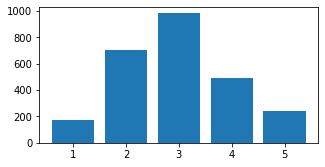

In [11]:
show_counts_per_class_of_labels(train)

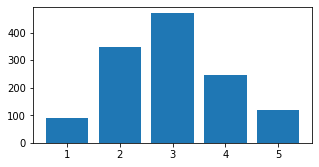

In [12]:
show_counts_per_class_of_labels(test)

### Wordcloud for data

In [13]:
from wordcloud import WordCloud

In [14]:
def create_wordcloud(data,data_name):
    
    # Generate a word cloud image
    fig, axs = plt.subplots(1, 5)
    plt.rcParams['figure.figsize'] = [120, 120]
    # lower max_font_size
    axs[0].imshow(WordCloud(max_font_size=60).generate(str((data[data.Score==1])['Content'].values)), interpolation="bilinear")
    axs[1].imshow(WordCloud(max_font_size=60).generate(str((data[data.Score==2])['Content'].values)), interpolation="bilinear")
    axs[2].imshow(WordCloud(max_font_size=60).generate(str((data[data.Score==3])['Content'].values)), interpolation="bilinear")
    axs[3].imshow(WordCloud(max_font_size=60).generate(str((data[data.Score==4])['Content'].values)), interpolation="bilinear")
    axs[4].imshow(WordCloud(max_font_size=60).generate(str((data[data.Score==5])['Content'].values)), interpolation="bilinear")
    [axi.set_axis_off() for axi in axs.ravel()]
    plt.show()
    name = data_name + '.png'
    fig.savefig(name, bbox_inches='tight')
    pass


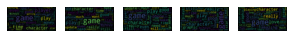

In [15]:
create_wordcloud(train,'train')

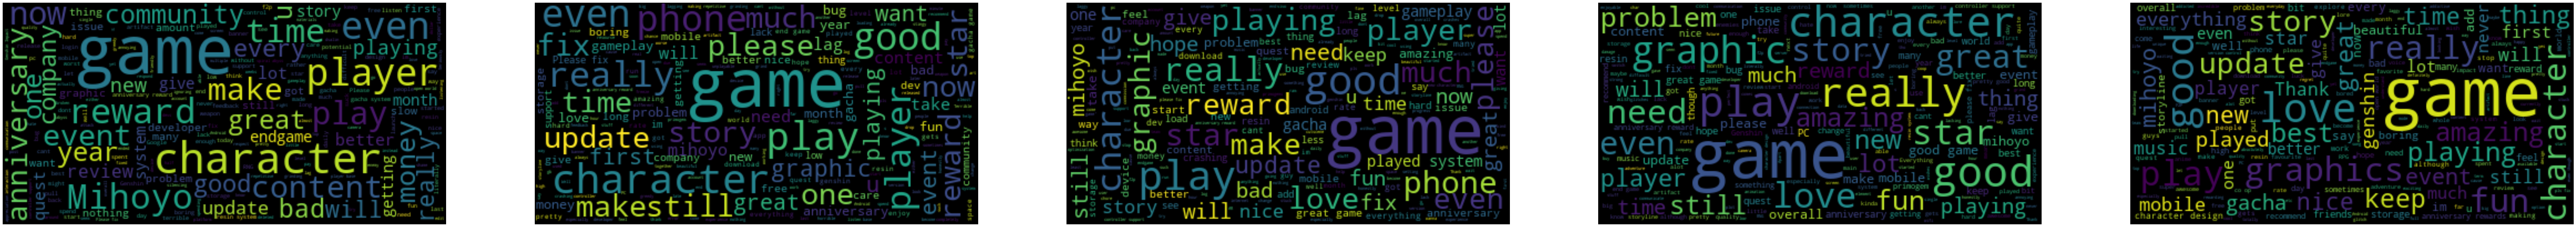

In [16]:
create_wordcloud(test,'test')

## Data Pre-processing

In [17]:
import spacy
import contextualSpellCheck
import re
import string

In [18]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [19]:
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe("contextual spellchecker", config={"max_edit_dist": 5}) 
punctuations = string.punctuation
stopwords = spacy.lang.en.stop_words.STOP_WORDS

### Spell check and language detect

In [20]:
train_filt = pd.DataFrame(columns=['Time', 'Score', 'Content'])
test_filt = pd.DataFrame(columns=['Time', 'Score', 'Content'])
def spell_check_and_language_detect(data,data_filter):
    for i in range(len(data)):
        data.iloc[i,2]=remove_emoji(str(data.iloc[i,2]))
        doc = nlp(data.iloc[i,2])
        data.iloc[i,2] = doc._.outcome_spellCheck
        data_filter = data_filter.append(data.iloc[i,:])
        pass
    return data_filter

In [21]:
# Use the filted data procceed before because of too long processing time
# train_filt = spell_check_and_language_detect(train,train_filt)
# test_filt = spell_check_and_language_detect(test,test_filt)
# train_filt.to_excel('train_data.xlsx', index=False)
# test_filt.to_excel('test_data.xlsx', index=False)

In [22]:
train_filt=pd.read_excel('train_data.xlsx')
test_filt=pd.read_excel('test_data.xlsx')

In [23]:
train_filt_na = train_filt.dropna()
train_filt_na = train_filt_na.reset_index(drop=True)

In [24]:
train_filt_na.shape 

(1640, 3)

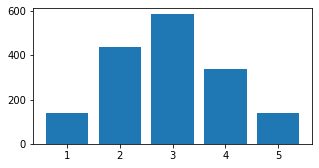

In [25]:
show_counts_per_class_of_labels(train_filt_na)

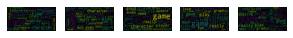

In [26]:
create_wordcloud(train_filt_na,'train_filt_na')

In [27]:
test_filt_na = test_filt.dropna()
test_filt_na = test_filt_na.reset_index(drop=True)

In [28]:
test_filt_na.shape 

(837, 3)

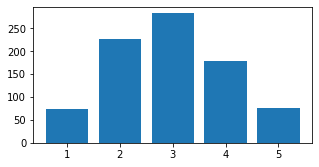

In [29]:
show_counts_per_class_of_labels(test_filt_na)

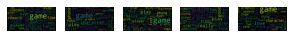

In [30]:
create_wordcloud(test_filt_na,'test_filt_na')

## Data Process

### Data Balance

In [31]:
from imblearn.over_sampling import SMOTE

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle

In [33]:
def preprocess(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.is_stop==False and token.lemma_.isalpha()==True]

In [34]:
vectorizer = CountVectorizer(tokenizer=preprocess)

In [35]:
# Because of too long processing time, I use the data proccessed before
# train_filt_x = vectorizer.fit_transform(train_filt_na['Content'])
# pickle.dump(train_filt_x, open('train_filt_x.pickle', 'wb'))
train_filt_x = pickle.load(open('train_filt_x.pickle', 'rb'))
train_filt_y = (train_filt_na['Score'].values).astype('int')

In [36]:
# Because of too long processing time, I use the data proccessed before
# test_filt_x = vectorizer.transform(test_filt_na['Content'])
# pickle.dump(test_filt_x, open('test_filt_x.pickle', 'wb'))
test_filt_x = pickle.load(open('test_filt_x.pickle', 'rb'))
test_filt_y = (test_filt_na['Score'].values).astype('int')

In [37]:
sm = SMOTE(random_state=2201)
train_bal_x, train_bal_y = sm.fit_resample(train_filt_x,train_filt_y)

## Non-deep learning methods

In [38]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

lsvc_model = LinearSVC() 
lsvc_model.fit(train_bal_x, train_bal_y) 
lsvc_test_pred = lsvc_model.predict(test_filt_x)
print(classification_report(test_filt_y, lsvc_test_pred))

              precision    recall  f1-score   support

           1       0.17      0.27      0.21        73
           2       0.34      0.32      0.33       227
           3       0.32      0.24      0.27       283
           4       0.27      0.28      0.28       179
           5       0.30      0.44      0.36        75

    accuracy                           0.29       837
   macro avg       0.28      0.31      0.29       837
weighted avg       0.30      0.29      0.29       837



In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
lr_model = LogisticRegression(random_state=2201,multi_class="multinomial", solver="lbfgs", max_iter=1000)
lr_model.fit(train_bal_x, train_bal_y)
lr_test_pred = lr_model.predict(test_filt_x)
print(classification_report(test_filt_y, lr_test_pred))

              precision    recall  f1-score   support

           1       0.13      0.19      0.15        73
           2       0.36      0.33      0.35       227
           3       0.35      0.29      0.32       283
           4       0.30      0.30      0.30       179
           5       0.34      0.45      0.39        75

    accuracy                           0.31       837
   macro avg       0.29      0.31      0.30       837
weighted avg       0.32      0.31      0.31       837



## deep learning methods

### Simple RNN

In [41]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [42]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [43]:
train_ds = train_filt_na.iloc[:,1:3]
test_ds = test_filt_na.iloc[:,1:3]

In [44]:
from sklearn.utils.class_weight import compute_class_weight

In [45]:
labels=np.unique(train_ds['Score'].values)
class_weights = compute_class_weight(class_weight='balanced',classes=labels, y=train_ds['Score'].values)
weights_of_class={labels[i]:v for i, v in enumerate(class_weights)}
weights_of_class.update({0:0})

In [46]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [47]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_ds['Content'])
train_ds_tf_x = tokenizer.texts_to_sequences(train_ds['Content']) 
test_ds_tf_x = tokenizer.texts_to_sequences(test_ds['Content'])

In [48]:
vocab_size = len(tokenizer.word_index) + 1 # Adding 1 because of reserved 0 index

In [49]:
maxlen = 100 
embedding_dim = 50
# keeping the last maxlen words, if two long.
train_dp_x = pad_sequences(train_ds_tf_x, padding='post', maxlen=maxlen) 
test_dp_x = pad_sequences(test_ds_tf_x, padding='post', maxlen=maxlen)
train_dp_y=tf.keras.utils.to_categorical(train_ds['Score'].astype('float32').values,num_classes=6)
test_dp_y=tf.keras.utils.to_categorical(test_ds['Score'].astype('float32').values,num_classes=6)


In [50]:
RNN_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=embedding_dim,input_length=maxlen),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(6, activation='sigmoid'),
])

In [51]:
RNN_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [52]:
RNN_history = RNN_model.fit(train_dp_x,train_dp_y,class_weight=weights_of_class, epochs=20,validation_split=0.2,batch_size=20)

Epoch 1/20
66/66 [==============================] - 1s 6ms/step - loss: 1.4899 - accuracy: 0.1555 - val_loss: 2.0293 - val_accuracy: 0.0030
Epoch 2/20
66/66 [==============================] - 0s 4ms/step - loss: 1.3874 - accuracy: 0.2233 - val_loss: 2.3403 - val_accuracy: 0.0000e+00
Epoch 3/20
66/66 [==============================] - 0s 4ms/step - loss: 1.3063 - accuracy: 0.2919 - val_loss: 2.6027 - val_accuracy: 0.0000e+00
Epoch 4/20
66/66 [==============================] - 0s 4ms/step - loss: 1.2449 - accuracy: 0.3064 - val_loss: 2.7490 - val_accuracy: 0.0000e+00
Epoch 5/20
66/66 [==============================] - 0s 4ms/step - loss: 1.1911 - accuracy: 0.3133 - val_loss: 2.8532 - val_accuracy: 0.0000e+00
Epoch 6/20
66/66 [==============================] - 0s 4ms/step - loss: 1.1470 - accuracy: 0.3460 - val_loss: 3.0379 - val_accuracy: 0.0000e+00
Epoch 7/20
66/66 [==============================] - 0s 4ms/step - loss: 1.1137 - accuracy: 0.3460 - val_loss: 3.1945 - val_accuracy: 0.0000e

In [53]:
test_loss, test_acc = RNN_model.evaluate(test_dp_x, test_dp_y)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

27/27 [==============================] - 0s 844us/step - loss: 1.8100 - accuracy: 0.3106
Test Loss: 1.8100287914276123
Test Accuracy: 0.31063321232795715


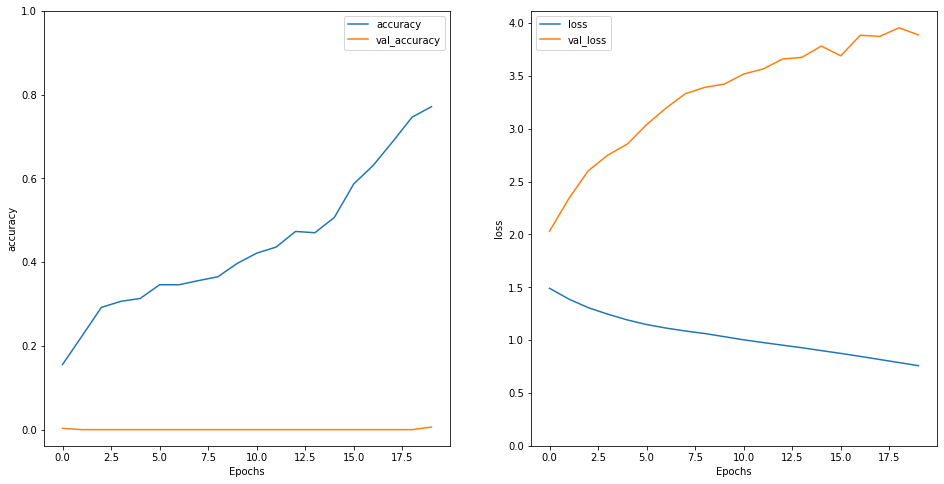

In [54]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(RNN_history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(RNN_history, 'loss')
plt.ylim(0, None)
plt.savefig('RNN', bbox_inches='tight')

### LSTM

In [55]:
LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=embedding_dim,input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(6, activation='sigmoid'),
])

In [56]:
LSTM_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                   optimizer=tf.keras.optimizers.Adam(1e-4),
                   metrics=['accuracy'])

In [57]:
LSTM_history = LSTM_model.fit(train_dp_x,train_dp_y,validation_split=0.2, epochs=20,batch_size=20)

Epoch 1/20
66/66 [==============================] - 5s 42ms/step - loss: 1.7403 - accuracy: 0.3956 - val_loss: 1.9069 - val_accuracy: 0.0000e+00
Epoch 2/20
66/66 [==============================] - 2s 32ms/step - loss: 1.4187 - accuracy: 0.4459 - val_loss: 2.9486 - val_accuracy: 0.0000e+00
Epoch 3/20
66/66 [==============================] - 2s 33ms/step - loss: 1.2519 - accuracy: 0.4459 - val_loss: 3.3011 - val_accuracy: 0.0000e+00
Epoch 4/20
66/66 [==============================] - 2s 32ms/step - loss: 1.2133 - accuracy: 0.4459 - val_loss: 3.4409 - val_accuracy: 0.0000e+00
Epoch 5/20
66/66 [==============================] - 2s 34ms/step - loss: 1.1972 - accuracy: 0.4459 - val_loss: 3.4890 - val_accuracy: 0.0000e+00
Epoch 6/20
66/66 [==============================] - 2s 32ms/step - loss: 1.1827 - accuracy: 0.4459 - val_loss: 3.8864 - val_accuracy: 0.0000e+00
Epoch 7/20
66/66 [==============================] - 2s 32ms/step - loss: 1.1629 - accuracy: 0.4459 - val_loss: 3.7035 - val_accura

In [58]:
test_loss, test_acc = LSTM_model.evaluate(test_dp_x, test_dp_y)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

27/27 [==============================] - 0s 11ms/step - loss: 2.4591 - accuracy: 0.3118
Test Loss: 2.4591219425201416
Test Accuracy: 0.31182795763015747


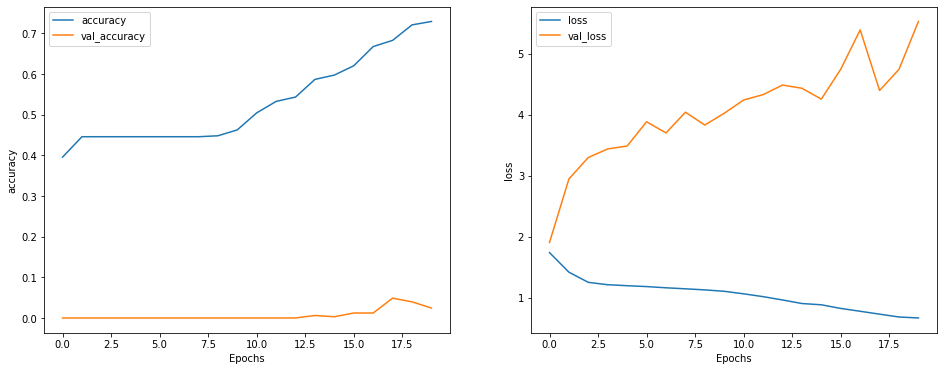

In [59]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(LSTM_history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(LSTM_history, 'loss')
plt.savefig('LSTM', bbox_inches='tight')

### BERT

In [60]:
# !wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [61]:
import tensorflow_hub as hub
import tokenization
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

INFO:absl:Using C:\Users\ShiCJ\AppData\Local\Temp\tfhub_modules to cache modules.


In [62]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [63]:
def build_BERT_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(6, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [64]:
max_len = 100
train_input = bert_encode(train_ds['Content'].values, tokenizer, max_len=max_len)
test_input = bert_encode(test_ds['Content'].values, tokenizer, max_len=max_len)
train_labels = tf.keras.utils.to_categorical(train_ds['Score'].values, num_classes=6)
test_labels = tf.keras.utils.to_categorical(test_ds['Score'].values, num_classes=6)

In [65]:
BERT_model = build_BERT_model(bert_layer, max_len=max_len)

In [66]:
BERT_history = BERT_model.fit(train_input, train_labels,validation_split=0.2, epochs=10,batch_size=20)

Epoch 1/10
66/66 [==============================] - 435s 6s/step - loss: 1.4315 - accuracy: 0.3826 - val_loss: 2.8755 - val_accuracy: 0.0000e+00
Epoch 2/10
66/66 [==============================] - 469s 7s/step - loss: 1.2224 - accuracy: 0.4726 - val_loss: 2.8535 - val_accuracy: 0.0091
Epoch 3/10
66/66 [==============================] - 507s 8s/step - loss: 1.1256 - accuracy: 0.5213 - val_loss: 3.0459 - val_accuracy: 0.0244
Epoch 4/10
66/66 [==============================] - 455s 7s/step - loss: 0.9932 - accuracy: 0.5800 - val_loss: 3.2085 - val_accuracy: 0.0579
Epoch 5/10
66/66 [==============================] - 443s 7s/step - loss: 0.8372 - accuracy: 0.6639 - val_loss: 3.1504 - val_accuracy: 0.1585
Epoch 6/10
66/66 [==============================] - 455s 7s/step - loss: 0.6613 - accuracy: 0.7454 - val_loss: 3.2167 - val_accuracy: 0.2927
Epoch 7/10
66/66 [==============================] - 463s 7s/step - loss: 0.5170 - accuracy: 0.8026 - val_loss: 3.9917 - val_accuracy: 0.1006
Epoch 8/1

In [68]:
test_loss, test_acc = BERT_model.evaluate(test_input,test_labels)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

27/27 [==============================] - 79s 3s/step - loss: 2.6781 - accuracy: 0.4146
Test Loss: 2.678116798400879
Test Accuracy: 0.41457587480545044


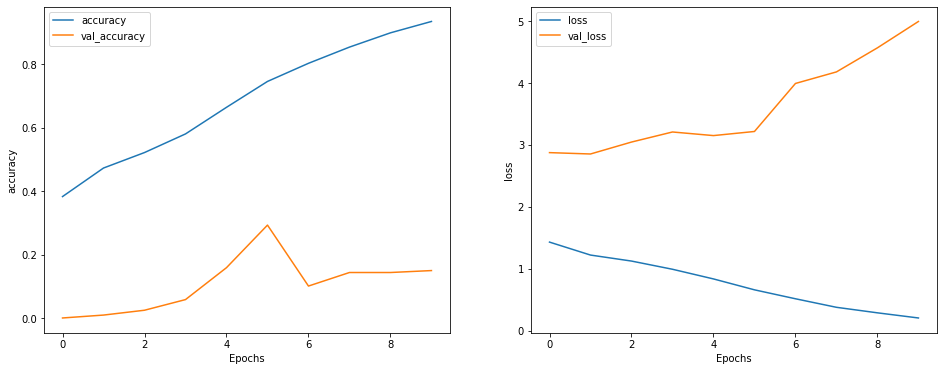

In [69]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(BERT_history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(BERT_history, 'loss')
plt.savefig('BERT', bbox_inches='tight')

# Reference

https://www.tensorflow.org/text/tutorials/classify_text_with_bert

https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python

https://github.com/JoMingyu/google-play-scraper

https://spacy.io/universe/project/contextualspellcheck/

https://spacy.io/universe/project/spacy_fastlang/

https://amueller.github.io/word_cloud/

https://www.tensorflow.org/text/tutorials/text_classification_rnn

https://www.tensorflow.org/guide/keras/rnn

https://www.analyticsvidhya.com/blog/2020/10/simple-text-multi-classification-task-using-keras-bert/